In [236]:
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import open3d
import seaborn as sns
import random
import sys
import math
from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids

# 1. 3D mesh reconstruction from a set of images from the Gerrard Hall dataset.

This exercise was used as an initial exploration of COLMAP in order to become familiar with its workflow, reconstruction pipeline, and the different representations it produces.

First, we installed Colmap and runned the automatic reconstruction on the Gerrard Hall dataset. This pipeline consists of two main stages: **sparse reconstruction** and **dense reconstruction**.

## Sparse reconstruction

After running the automatic reconstruction, we visualized the *sparse* reconstruction directly in COLMAP. This visualization shows the recovered camera poses (in red) and the 3D sparse point cloud representing the structure of the scene. As shown in **Figure 1**, this sparse model allows us to verify that the cameras have been correctly localized and that the general geometry of the scene has been recovered.

<p align="center">
  <img src="figures/gerrard_hall_colmap.png" width="45%">
</p>
<p align="center"><b>Figure 1:</b> Sparse reconstruction visualized in COLMAP, showing the estimated camera poses (red) and the sparse 3D point cloud.</p>

## Dense reconstruction

Once the sparse reconstruction was completed, COLMAP computed a *dense* reconstruction, which produces a much denser point cloud and allows generating a surface mesh.

For the meshing step, different reconstruction methods can be used, such as:

* **Poisson Meshing**: Produces smooth and detailed surfaces, preserving fine geometric details and color information. However, it may introduce holes or missing regions in areas with insufficient data.

* **Delaunay Meshing**: Produces a more complete surface and tends to close gaps, but usually lacks fine details and does not preserve color information as well as Poisson.

A visual comparison between the two meshing strategies is shown in **Figure 2**. In our case, we chose the **Poisson** mesher for the reconstruction, as it provided better visual quality, finer details, and more accurate color information.


<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson.png" width="85%">
    <p><b>(a)</b> Poisson mesh reconstruction.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_delaunay.png" width="85%">
    <p><b>(b)</b> Delaunay mesh reconstruction.</p>
  </div>
</div>

<p align="center"><b>Figure 2:</b> Comparison between Poisson and Delaunay meshing. The Poisson mesh preserves fine geometric details and color information, while the Delaunay mesh produces a more complete but less detailed surface.</p>

After selecting the Poisson mesher, COLMAP produced two different mesh representations: 

* `meshed-poisson.ply`: A smooth surface mesh obtained via Poisson reconstruction. It preserves fine details and color but may contain holes or artifacts.

* `fused.ply`: A fused point-based surface representation, which is less smooth but more directly connected to the original dense point cloud.

A visual comparison between both representations is shown in **Figure 3**. 

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson.png" style="width: 85%;">
    <p><b>(a)</b> <code>meshed-poisson.ply</code></p>
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson_fused.png" style="width: 85%;">
    <p><b>(b)</b> <code>fused.ply</code></p>
  </div>
</div>

<p align="center"><b>Figure 3:</b> Comparison between the two mesh representations generated by COLMAP. The Poisson mesh (a) produces a smoother and more visually detailed surface, while the fused representation (b) is noisier but more directly connected to the original dense point cloud.</p>

Based on this comparison, we selected the `meshed-poisson.ply` representation as our "final" mesh, as it provides smoother surfaces, better geometric details, and more accurate color information. Although it may contain some small holes or artifacts, these can be corrected through post-processing. 

## Mesh Post-processing

As we can see in **Figure 4**, the raw mesh contained several artifacts and noisy components, especially around the borders and less constrained regions.

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_before_1.png" style="width: 85%;">
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_before_2.png" style="width: 85%;">
  </div>
</div>
<p align="center"><b>Figure 4:</b> Two different views of the raw <code>meshed-poisson.ply</code> mesh, showing artifacts and noisy regions, especially near the borders.</p>


To improve the final result, we applied different cleaning filters in MeshLab, such as:

*  **Removing isolated components (wrt Diameter)**, 
* **Manually removed a connected region** that corresponded to a reconstruction artifact by selecting the undesired faces with a rectangular selection tool and deleting the selected vertices and faces. 

**Figure 5** hows the cleaned versions of the previous meshes, obtained after applying the post-processing steps described above.

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_after_1.png" style="width: 85%;">
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_after_2.png" style="width: 85%;">
  </div>
</div>
<p align="center"><b>Figure 5:</b> Two different views of the cleaned <code>meshed-poisson.ply</code> mesh after post-processing, showing a significant reduction of artifacts and noisy regions.</p>


The final processed mesh can be downloaded from the following link:
[Gerrard Hall Mesh](https://drive.google.com/file/d/1yNNZeB9sxfI0jd5833KQu7Z_Lk0r3WLD/view?usp=drive_link)

# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [377]:
# Add your path
reconstruction_path = "./gerrard-hall/sparse/0"
database_path = "./gerrard-hall/database.db"

#### Load an existing reconstruction and print its contents

In [378]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

In [379]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [380]:
print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1]) 

Loaded 100 images. This is the information available for one of them:
Image(id=1, qvec=array([ 0.63708369,  0.22429394, -0.25600195,  0.69157762]), tvec=array([-0.72194622, -1.9670957 ,  2.73841702]), camera_id=1, name='IMG_2387.JPG', xys=array([[ 758.38574219,   61.36777496],
       [2757.86962891,   11.28521633],
       [2775.62963867,   33.56768417],
       ...,
       [1864.0871582 , 3612.57421875],
       [2398.2121582 , 3603.64233398],
       [2398.2121582 , 3603.64233398]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

Loaded 1 cameras. This is the information available for one of them:
Camera(id=1, model='OPENCV', width=5616, height=3744, params=array([ 3.83803963e+03,  3.83703349e+03,  2.80800000e+03,  1.87200000e+03,
       -1.10256401e-01,  7.93806018e-02,  1.17244277e-04,  2.84898767e-04]))

Loaded 42815 3D points. This is the information available for one of them:
Point3D(id=1, xyz=array([-0.03336308, -1.54452335, -1.58907061]), rgb=array([205, 210, 213]), error=arra

#### Load the database

In [381]:
db = sqlite3.connect(database_path)

In [382]:
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

In [300]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

Loaded keypoints from 100 images. These are the 24414 keypoints for one of them:
[[7.5838574e+02 6.1367775e+01]
 [4.0777049e+00 2.3697526e+00]
 [2.7578696e+03 1.1285216e+01]
 ...
 [4.2930962e+01 4.8993421e+00]
 [2.3982122e+03 3.6036423e+03]
 [4.2930962e+01 2.5109098e+00]]


In [301]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

Loaded 2153 matches. 2797/4950 matches contained no data


In [302]:
# Temporal
dir(matches)
matches.__class__
matches.items()
matches.keys()

dict_keys([(1.0, 3), (1.0, 18), (1.0, 26), (1.0, 27), (1.0, 28), (1.0, 35), (1.0, 38), (1.0, 39), (1.0, 42), (1.0, 44), (1.0, 50), (1.0, 56), (1.0, 62), (1.0, 63), (1.0, 64), (1.0, 67), (1.0, 70), (1.0, 75), (1.0, 85), (1.0, 89), (1.0, 99), (2.0, 5), (2.0, 6), (2.0, 7), (2.0, 8), (2.0, 13), (2.0, 20), (2.0, 21), (2.0, 22), (2.0, 23), (2.0, 24), (2.0, 30), (2.0, 32), (2.0, 33), (2.0, 35), (2.0, 37), (2.0, 41), (2.0, 44), (2.0, 45), (2.0, 52), (2.0, 64), (2.0, 65), (2.0, 67), (2.0, 68), (2.0, 69), (2.0, 71), (2.0, 73), (2.0, 77), (2.0, 78), (2.0, 81), (2.0, 84), (2.0, 85), (2.0, 89), (2.0, 93), (2.0, 95), (2.0, 97), (2.0, 98), (3.0, 4), (3.0, 14), (3.0, 15), (3.0, 18), (3.0, 26), (3.0, 27), (3.0, 28), (3.0, 35), (3.0, 38), (3.0, 39), (3.0, 42), (3.0, 44), (3.0, 47), (3.0, 49), (3.0, 50), (3.0, 56), (3.0, 57), (3.0, 62), (3.0, 63), (3.0, 64), (3.0, 67), (3.0, 69), (3.0, 70), (3.0, 71), (3.0, 74), (3.0, 75), (3.0, 79), (3.0, 85), (3.0, 89), (3.0, 94), (3.0, 96), (3.0, 99), (4.0, 5), (4.0, 

In [303]:
print("These are the matches between two images:")
print(matches[1,3])

These are the matches between two images:
[[1459   68]
 [8054  481]
 [8113  482]
 [8114  483]
 [8187  484]
 [6590  512]
 [8009  603]
 [8053  608]
 [8184  611]
 [8111  612]
 [8112  613]
 [8052  774]
 [8182  775]
 [8181  777]
 [5326  783]
 [5806  797]
 [8005  903]
 [8107  907]
 [8110  909]
 [8048  910]
 [8049  911]
 [8180  914]
 [8177  915]
 [8175  916]
 [5067  917]
 [8178  919]
 [5800  926]
 [6416  939]
 [8002 1041]
 [8000 1043]
 [8001 1044]
 [8044 1050]
 [5684 1062]
 [7995 1191]
 [8104 1192]
 [8099 1194]
 [8097 1196]
 [8100 1197]
 [8096 1198]
 [8169 1200]
 [8171 1201]
 [6658 1223]
 [8039 1339]
 [8092 1340]
 [8088 1341]
 [8094 1342]
 [8168 1343]
 [6477 1384]
 [7172 1397]
 [7173 1398]
 [7170 1399]
 [7168 1400]
 [7994 1491]
 [7991 1492]
 [7992 1493]
 [8036 1496]
 [7993 1498]
 [8087 1505]
 [5912 1525]
 [7003 1549]
 [7002 1550]
 [7986 1684]
 [8032 1685]
 [8165 1687]
 [8163 1688]
 [6570 1709]
 [6565 1710]
 [7237 1735]
 [8033 1855]
 [8031 1856]
 [8086 1857]
 [8085 1858]
 [8162 1860]
 [5436 18

#### Visualize the point cloud and cameras

In [304]:
model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [305]:
print(f"#Keypoints total: {sum(kpts.shape[0] for kpts in keypoints.values())}")

#Keypoints total: 2123400


<span style='color:darkcyan'>There are 2123400 keypoints in total.</span> 

#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [306]:
num_points3d_originated_in_image_1 = sum(1 for point3D in points3D.values() if 1 in point3D.image_ids)

print(f"#3d points from image 1: {num_points3d_originated_in_image_1}")

#3d points from image 1: 2824


<span style='color:darkcyan'>There are 2824 keypoints in image 1.</span> 

## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

In [15]:
xyz = []
num_images = []
errors = []

for point3D in points3D.values():
    xyz.append(point3D.xyz)
    num_images.append(len(point3D.image_ids))
    errors.append(point3D.error)

xyz = np.array(xyz)
num_images = np.array(num_images)
errors = np.array(errors)

num_images_norm = (num_images - num_images.min()) / (num_images.max() - num_images.min())
errors_norm = (errors - errors.min()) / (errors.max() - errors.min())


colors_by_images = cm.jet(num_images_norm)[:, :3]
colors_by_error = cm.jet(errors_norm)[:, :3]

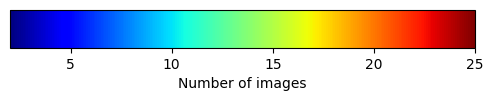

In [16]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=num_images.min(), vmax=num_images.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Number of images')
plt.show()

In [17]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_images)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

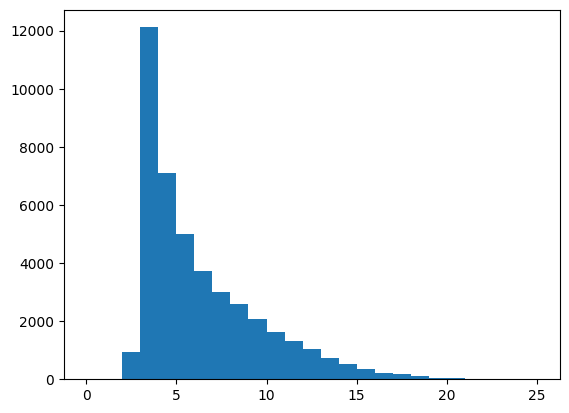

In [18]:
# Let's plot a histogram too
images_per_point3d = [len(p3d.image_ids) for p3d in points3D.values()]
counts, bins = np.histogram(images_per_point3d, bins=[i for i in range(max(images_per_point3d) + 1)])
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>Most points are visible from a few images. MORE</span> 

#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

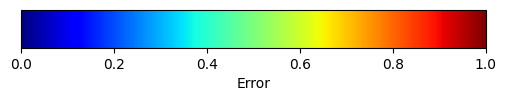

In [19]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=errors_norm.min(), vmax=errors_norm.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Error')
plt.show()

In [20]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_error)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

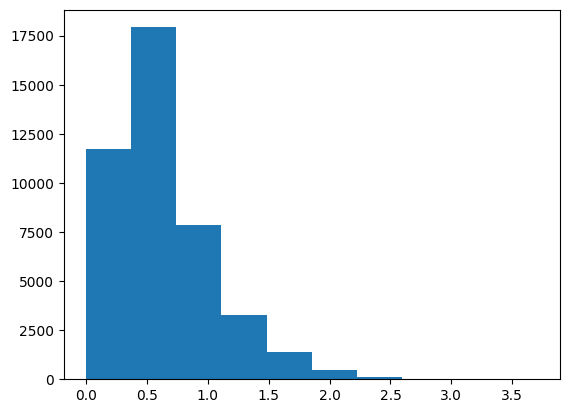

In [21]:
# Let's plot a histogram too
error_per_point3d = [p3d.error for p3d in points3D.values()]
counts, bins = np.histogram(error_per_point3d)
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>The error property of a 3D point is the average reprojection error of the point accross all images that can see said point.</span> 

<span style='color:darkcyan'>The error of the 3D points seems to have a more normal distribution. MORE</span> 

## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


In [22]:
xyz = []
colors = []

for point3D in points3D.values():
    if 1 not in point3D.image_ids:
        continue
    xyz.append(point3D.xyz)
    colors.append(point3D.rgb / 255)

vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

<class 'numpy.ndarray'>
(24414, 2)
float32
<class 'read_write_model.Image'>
<class 'numpy.ndarray'>


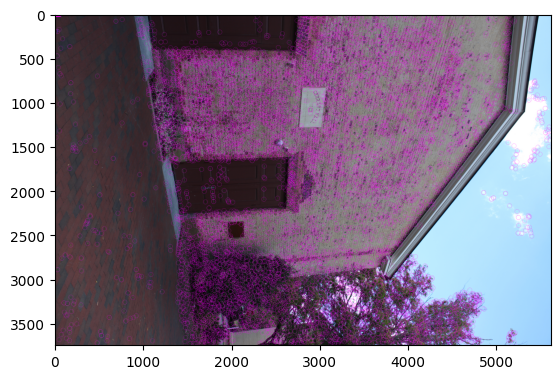

In [23]:
image1_keypoints = keypoints[1]

cv_keypoints = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=50) 
                for pt in image1_keypoints]


images_path = "./gerrard-hall/images/"

print(type(image1_keypoints))
print(image1_keypoints.shape)
print(image1_keypoints.dtype)

print(type(images[1]))

im1 = cv2.imread(images_path + images[1].name)
print(type(im1))
im_with_kpts = cv2.drawKeypoints(im1, cv_keypoints, None, 
                                   color=(255, 0, 255),
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

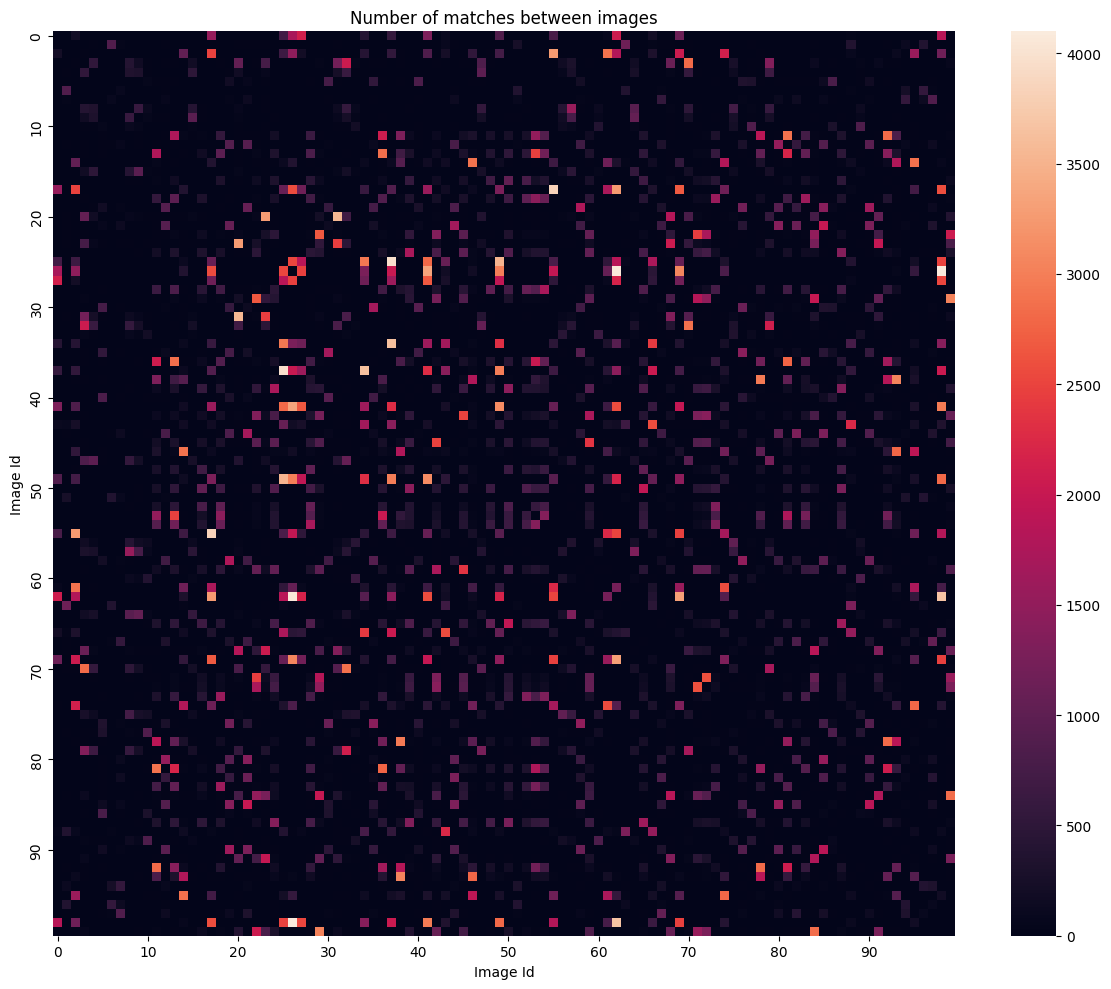

In [24]:
num_images = max(images.keys())
match_matrix = np.zeros((num_images, num_images), dtype=np.int32)
for (id1, id2), match_data in matches.items():
    i, j = int(id1) - 1, int(id2) - 1
    num_matches = len(match_data)
    match_matrix[i, j] = num_matches
    match_matrix[j, i] = num_matches

plt.figure(figsize=(12, 10))
sns.heatmap(match_matrix, xticklabels=10, yticklabels=10)
plt.xlabel('Image Id')
plt.ylabel('Image Id')
plt.title('Number of matches between images')
plt.tight_layout()
plt.show()

<span style='color:darkcyan'>Matches are concentrated around each image. An image won't have matches with images too far apart, as they represent different parts of the scene - images far appart may show different facades of the building. The fact that the corners of the heatmap are not 0 indicates that the last few images match with the first ones, indicating a somewhat closed track.</span> 

## 2.5 Visualize the keypoints and matches between the two images used in lab 3 using Colmap, how it compares to the results from lab 3? (1.0)
#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 3 to get comparable results. </span>

As shown in **Figure 6**, for this section, we will use the images `0001_s.png` and `0002_s.png`. 

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/0001_s.png" width="85%">
    <p><b>(a)</b> <code> 0001_s.png </code> </p>
  </div>
  <div style="text-align: center;">
    <img src="figures/0002_s.png" width="85%">
    <p><b>(b)</b> <code> 0002_s.png </code> </p>
  </div>
</div>
<p align="center">
  <b>Figure 6:</b> Input image pair used for keypoint detection and matching experiments: 
  (a) <code>0001_s.png</code> and (b) <code>0002_s.png</code>.
</p>

In Lab 3, the keypoints and correspondences were obtained using a classical pipeline: keypoint detection with ORB, brute-force matching, and outlier rejection using RANSAC.

Now, instead, we use COLMAP to compute the keypoints and matches. COLMAP employs more advanced and robust feature detection and description methods, such as SIFT, as well as more reliable matching strategies (e.g., exhaustive, sequential, or spatial matching), which typically provide more accurate and consistent correspondences.

To do this, we performed an automatic reconstruction in COLMAP using the two images `0001_s.png` and `0002_s.png`, and we follow the steps described in Section 2.1 to obtain the keypoints and matches.

The same procedure can also be carried out manually by running `Processing > Feature Extraction` (selecting the camera model) and then `Processing > Feature Matching`, choosing the desired matching strategy. However, by using the automatic reconstruction, all the required data are already prepared and can be directly reused in Sections 2.6 and 2.7.


In [307]:
reconstruction_path = "./castle/sparse/0"
database_path = "./castle/database.db"

model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

images = model.images
cameras = model.cameras
points3D = model.points3D

print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1]) 

db = sqlite3.connect(database_path)

Loaded 2 images. This is the information available for one of them:
Image(id=1, qvec=array([1., 0., 0., 0.]), tvec=array([-4.48232756,  0.51827378,  2.15409656]), camera_id=1, name='0002_s.png', xys=array([[751.6295166 , 431.08297729],
       [364.11279297, 383.38278198],
       [503.05007935, 486.63323975],
       ...,
       [ 27.28464699, 488.06100464],
       [349.95928955, 147.15539551],
       [178.17256165, 417.12347412]]), point3D_ids=array([  -1,   -1,   -1, ..., 1870,   -1,   -1]))

Loaded 1 cameras. This is the information available for one of them:
Camera(id=1, model='SIMPLE_RADIAL', width=922, height=614, params=array([ 8.10458864e+02,  4.61000000e+02,  3.07000000e+02, -2.86071716e-02]))

Loaded 1870 3D points. This is the information available for one of them:
Point3D(id=1, xyz=array([26.38841424, -5.57855398, 52.98490477]), rgb=array([116, 137, 186]), error=array(0.79802245), image_ids=array([1, 2]), point2D_idxs=array([3, 3]))


In [308]:
images = dict(
    (image_id, name)
    for image_id, name in db.execute(
        "SELECT image_id, name FROM images")
)

# Shifted ids!!!
print(images)

{2: '0001_s.png', 1: '0002_s.png'}


<span style="color:red; font-weight:bold;">Attention:</span>

In COLMAP, keypoints are stored in the database as a binary BLOB with shape 
<strong>(rows × cols)</strong>, where <code>rows</code> is the number of keypoints and 
<code>cols</code> is the number of values per keypoint.

According to the COLMAP documentation:
    "*If the keypoints have 4 columns, the feature
    geometry is a similarity and the third and fourth columns correspond to the scale and
    orientation of the feature, following SIFT conventions. If the keypoints have 6 columns,
    the feature geometry is an affinity and the last four columns encode the affine shape
    of the feature.*"

In our case, <code>cols = 6</code>. Therefore, using <code>reshape(-1, 6)</code> reconstructs each
keypoint correctly as a row with six values. Since only the 2D image coordinates are
required for visualization and matching, we keep only the first two columns
<code>(x, y)</code> and discard the remaining attributes.


In [265]:
for image_id, rows, cols in db.execute(
        "SELECT image_id, rows, cols FROM keypoints"):
    print(f"image_id={image_id}, rows={rows}, cols={cols}")

keypoints = dict(
    (image_id, blob_to_array(data, np.float32, (-1, 6))[:, :2]) 
    for image_id, data in db.execute(
        "SELECT image_id, data FROM keypoints")
)
print(f"Loaded keypoints from {len(keypoints)} images")
print(f"Total keypoints: {sum(kpts.shape[0] for kpts in keypoints.values())}")
print(f"These are the {len(keypoints[2])} keypoints in the first image and {len(keypoints[1])} keypoints in the second image")

image_id=1, rows=3837, cols=6
image_id=2, rows=4207, cols=6
Loaded keypoints from 2 images
Total keypoints: 8044
These are the 4207 keypoints in the first image and 3837 keypoints in the second image


In [266]:
image1 = cv2.imread('./castle/Images/0001_s.png')
image2 = cv2.imread('./castle/Images/0002_s.png')

# Convert keypoints to cv2.KeyPoint format
kp1 = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in keypoints[2]] 
kp2 = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in keypoints[1]]

def show_keypoints(image, cv_keypoints, title="Keypoints"):
    im_with_kpts = cv2.drawKeypoints(
        image, 
        cv_keypoints, 
        None,
        color=(255, 0, 255),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

show_keypoints(image1, kp1, title="Keypoints Image 1")
show_keypoints(image2, kp2, title="Keypoints Image 2")

In [267]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} match. ")
print(f"There are {len(matches[1,2])} matches between the two images.")

Loaded 1 match. 
There are 1571 matches between the two images.


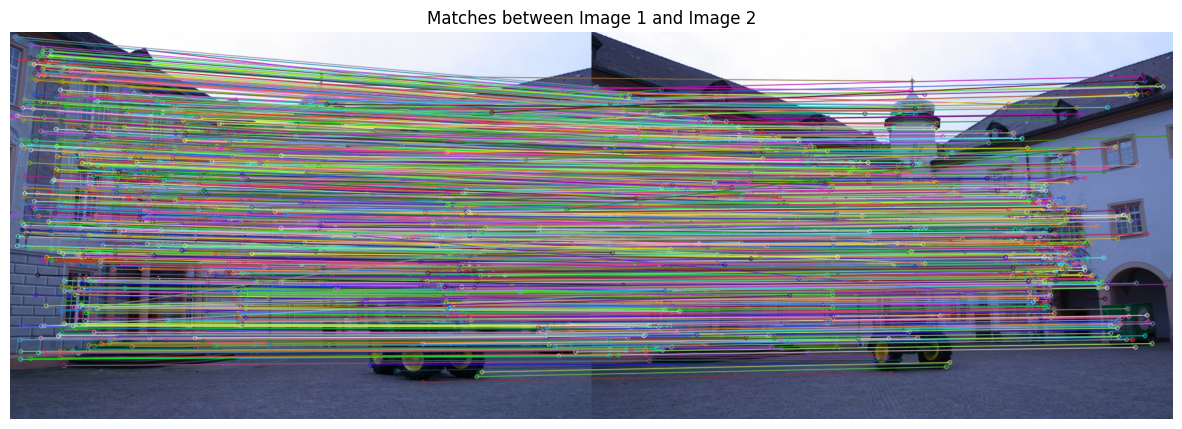

In [268]:
# Convert matches to cv2.DMatch format
cv_matches = []
for match in matches[(1, 2)]:
    query_idx = int(match[1])  
    train_idx = int(match[0]) 
    cv_matches.append(cv2.DMatch(_queryIdx=query_idx, _trainIdx=train_idx, _distance=0))

# Draw matches
img_matches = cv2.drawMatches(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB), kp1, cv2.cvtColor(image2, cv2.COLOR_BGR2RGB), kp2, cv_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.axis('off')
plt.title('Matches between Image 1 and Image 2')
plt.show()

As we can see from the obtained results, the number of matches obtained with COLMAP is very high (**1571**), and most of them appear to be geometrically consistent. However, from a visual inspection alone, it is not possible to determine with certainty if all correspondences are true inliers. 

However, by randomly visualizing small subsets of the matches, we were able to identify some outliers (up to 6) that are not easily noticeable when all correspondences are displayed at once. This confirms that a purely visual inspection is not sufficient to reliably separate correct matches from incorrect ones when there are many matches obtained.


In [270]:
def draw_match_sample(img1, kp1, img2, kp2, matches, n=10, title=""):
    if len(matches) > n:
        matches = random.sample(matches, n)
    vis = cv2.drawMatches(
        cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), kp1,
        cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(16, 10))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(title)
    plt.show()

draw_match_sample(image1, kp1, image2, kp2, cv_matches, n=50, title="Random Matches")


If we compare these results with those obtained in Lab 3, we can observe some differences.

In Lab 3, we obtained **1290** raw matches before applying RANSAC, which were reduced to **650** inliers after geometric verification. This clearly shows that a significant number of outliers were present and that applying RANSAC was essential to remove incorrect correspondences. The effect of this filtering step can be clearly observed in **Figure 7**.

ORB is a simpler and faster descriptor, and it generally detects fewer keypoints compared to SIFT. As a result, the total number of matches is lower. However, after RANSAC, the remaining correspondences appear to be more geometrically consistent (*although, as mentioned before, a purely visual inspection is not sufficient to guarantee that all matches are true inliers; by randomly sampling small subsets, we were only able to identify at most **two** remaining outliers*). This suggests that, although fewer matches are obtained, they may be more reliable.


<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center; width: 45%;">
    <img src="figures/lab3_matches_before_ransac.png" style="width: 100%;">
    <p><b>(a)</b> Matches before RANSAC (1290).</p>
  </div>
  <div style="text-align: center; width: 45%;">
    <img src="figures/lab3_matches_after_ransac.png" style="width: 100%;">
    <p><b>(b)</b> Matches after RANSAC (650).</p>
  </div>
</div>

<p align="center">
  <b>Figure 7:</b> Comparison of Lab 3 results before and after applying RANSAC. 
  A large number of incorrect correspondences are removed after geometric verification, 
  leading to a more consistent set of matches.
</p>

Overall, this comparison highlights an important trade-off between both approaches. Simpler methods such as ORB may produce fewer correspondences, but these can be highly consistent after geometric filtering. On the other hand, more advanced pipelines tend to generate a much denser set of matches, which is beneficial for tasks such as 3D reconstruction, even if some outliers are introduced. In the case of COLMAP, the number of outliers appears to be very small based on our visual inspection compared to the inliers, resulting in a high inlier ratio. This indicates that COLMAP’s matching strategy is robust and reliable, providing a dense set of correspondences while maintaining good geometric consistency.


## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 3, how it compares to the results from lab 3? (1.0) 
#### <span style='color:Green'> - Use the triangulation from lab 3 to the get the 3D points and visualize them following the same style. </span>

In [374]:
img1_id, img2_id = 2, 1  # Shifted ids

# Get the images
img1 = images[img1_id]
img2 = images[img2_id]

# Get the camera (shared intrinsics)
camera = cameras[img1.camera_id]

print("Camera information (shared intrinsics):")
print(f"Camera ID    : {camera.id}")
print(f"Model        : {camera.model}")
print(f"Image size   : {camera.width} x {camera.height}")
print(f"Parameters   : [f, cx, cy, k] = {camera.params}")

# Intrinsic matrix
f, cx, cy, k = camera.params
K = np.array([[f, 0,  cx],
              [0, f,  cy],
              [0, 0,  1]], dtype=float)

print("\nIntrinsic matrix K:")
print(K)

# Projection matrices
def P_from_image(img, K):
    R = img.qvec2rotmat()
    t = img.tvec.reshape(3, 1)
    return K @ np.hstack([R, t])

P1 = P_from_image(img1, K)
P2 = P_from_image(img2, K)

print("\nProjection matrices (P = K [R | t]):")
print("P1 shape:", P1.shape)
print(P1)
print("\nP2 shape:", P2.shape)
print(P2)

# Camera centers
C1 = -img1.qvec2rotmat().T @ img1.tvec
C2 = -img2.qvec2rotmat().T @ img2.tvec

print("\nCamera centers in world coordinates:")
print(f"C1: {C1}")
print(f"C2: {C2}")

Camera information (shared intrinsics):
Camera ID    : 1
Model        : SIMPLE_RADIAL
Image size   : 922 x 614
Parameters   : [f, cx, cy, k] = [ 8.10458864e+02  4.61000000e+02  3.07000000e+02 -2.86071716e-02]

Intrinsic matrix K:
[[810.45886377   0.         461.        ]
 [  0.         810.45886377 307.        ]
 [  0.           0.           1.        ]]

Projection matrices (P = K [R | t]):
P1 shape: (3, 4)
[[ 8.72253180e+02 -4.59305188e+01  3.26235111e+02  3.23078717e+03]
 [ 8.98967210e+01  8.05507378e+02  3.06869701e+02 -6.75553762e+02]
 [ 1.58598364e-01 -1.26853857e-02  9.87261688e-01 -1.40919265e+00]]

P2 shape: (3, 4)
[[ 8.10458864e+02  0.00000000e+00  4.61000000e+02 -2.63970359e+03]
 [ 0.00000000e+00  8.10458864e+02  3.07000000e+02  1.08134722e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.15409656e+00]]

Camera centers in world coordinates:
C1: [-4.4823276   0.51827378  2.15409653]
C2: [ 4.48232756 -0.51827378 -2.15409656]


In [375]:
# Lab3 code for triangulation
def image_normalization_matrix(imsize):
    #Normalization matrix based on image size, maps image coordinates to [-1,1] range
    w, h = imsize
    return np.array([
        [2 / w,     0,     -1], #Scale x-coordinates to [-1, 1]
        [0,     2 / h,     -1], #Scale y-coordinates to [-1, 1]
        [0,         0,      1]
    ])

def hartley_normalization_matrix(x: np.ndarray) -> np.ndarray:
    #Normalization matrix based on Hartley normalization
    x = x.copy()
    x = x / x[2:3, :]                #Homogeneous to Euclidean coordinates
    pts = x[:2, :]                   #2D image coordinates

    c = np.mean(pts, axis=1)         #Centroid
    pts_c = pts - c[:, None]         #Translate points to centroid

    d = np.sqrt(np.sum(pts_c**2, axis=0)) #Euclidean distance to centroid
    mean_d = np.mean(d)                   #Mean distance from the centroid

    s = np.sqrt(2) / (mean_d + 1e-12) #Scale to get mean distance equals sqrt(2)

    T = np.array([
        [s, 0, -s * c[0]],
        [0, s, -s * c[1]],
        [0, 0, 1]
    ], dtype=float)         #Norm Matrix
    return T

def triangulate(x1, x2, P1, P2, imsize, norm='hartley') -> np.ndarray:
    #Triangulate 3D points from two views using the DLT method
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3

    #Apply normalization to improve numerical stability
    if norm == 'image_size':
        T = image_normalization_matrix(imsize)
        P1n = T @ P1
        P2n = T @ P2
        x1n = T @ x1
        x2n = T @ x2
    elif norm == 'hartley':
        T1 = hartley_normalization_matrix(x1)
        T2 = hartley_normalization_matrix(x2)
        P1n = T1 @ P1
        P2n = T2 @ P2
        x1n = T1 @ x1
        x2n = T2 @ x2
    elif norm is None:
        P1n, P2n, x1n, x2n = P1, P2, x1, x2
    else:
        raise ValueError("norm must be None, 'image_size' or 'hartley'")

    def generate_Ai(x, P):
        #Construct the DLT constraint matrix for a single correspondenc
        x = x.copy()
        x = x / x[2] #Dehomogenize image point
        u, v = x[0], x[1]
        return np.vstack([
            v * P[2,:] - P[1,:],
            P[0,:] - u * P[2,:]
        ])

    N = x1.shape[1]
    X = np.zeros((4, N), dtype=float) #Homogeneous 3D points

    for i in range(N):
        #Build the full DLT system by stacking constraints from both views
        A = np.vstack([
            generate_Ai(x1n[:, i], P1n),
            generate_Ai(x2n[:, i], P2n)
        ])

        #Solve A X = 0 using SVD
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        Xi = Vt[-1, :] #Solution associated with smallest singular value

        #Normalize homogeneous coordinates
        if abs(Xi[3]) > 1e-12:
            Xi = Xi / Xi[3]

        X[:, i] = Xi

    return X

In [376]:
m = matches[(1, 2)]   # shape (M,2)

idx1 = m[:, 1]        # indices in image 1 keypoints
idx2 = m[:, 0]        # indices in image 2 keypoints

x1 = keypoints[img1_id][idx1].T  # shape (2,M)
x2 = keypoints[img2_id][idx2].T  # shape (2,M)

x1 = np.vstack([x1, np.ones((1, x1.shape[1]))]) # shape (3,M)
x2 = np.vstack([x2, np.ones((1, x2.shape[1]))]) # shape (3,M)

# Triangulate points with Lab3 code
imsize = (camera.width, camera.height)
X = triangulate(x1, x2, P1, P2, imsize, norm='hartley')

X_eucl = X/X[-1,:]
points3d = X[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color='rgb(30, 100, 200)', size=2)))
fig.show()

## 2.7 Visualize the sparse reconstruction using the 2 images from lab 3, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

In [49]:
### TO DO 2.7

# 3. Configure the reconstruction to improve the results. (1.0)

# 4. Reconstruct a 3D mesh from images captured by you. (1.5)

Before taking our own photographs, we ensured that the camera focus and exposure were fixed. This was done to keep the camera parameters consistent across all images and to avoid changes in appearance that could negatively affect feature matching and reconstruction.

## UPF Campus

To reconstruct the UPF Campus, we captured the images using two different strategies in order to evaluate which one produced better reconstruction results.

* In the **first strategy**, we stood approximately at the center of the campus and took photos while rotating around ourselves, capturing images in all directions with good overlap.

* In the **second strategy**, we walked close to the campus walls and took photos of the opposite façades, moving around the campus in a roughly rectangular path.

**Figure 8** shows the *sparse* reconstructions obtained with each acquisition strategy.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="figures/approach_1.png" style="width: 73%;">
    <p><b>(a)</b> Sparse reconstruction using the first strategy.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/approach_2.png" style="width: 85%;">
    <p><b>(b)</b> Sparse reconstruction using the second strategy.</p>
  </div>
</div>

<p align="center">
  <b>Figure 8:</b> Sparse reconstructions of the UPF Campus obtained with two different image acquisition strategies.
</p>

We did not initially expect the first strategy to produce a spherical-like reconstruction. However, after analyzing the result of the second strategy, this behavior became more understandable.

Since the images in the first strategy were captured from a single location while rotating around the camera, the camera centers remain almost at the same position and only the viewing direction changes. As a result, the reconstructed points are distributed around the camera, forming a spherical structure.

In contrast, in the second strategy the camera is physically moved along the campus perimeter. This produces a clearer camera trajectory and leads to a reconstruction that better reflects the actual spatial layout of the scene.

Therefore, we selected the **second strategy** to perform the final reconstruction of the UPF Campus.



